In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math

In [14]:
def dateparse (time_in_secs):
    return datetime.datetime.fromtimestamp(float(time_in_secs))

In [15]:
rating_data = pd.read_csv('ratings.csv', parse_dates=['timestamp'])
movie_data = pd.read_csv('movies.csv')
rating_data1 = rating_data.pivot(index='userId',columns='movieId',values='rating')

In [16]:
movie_data.info()
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048575 non-null  int64  
 1   movieId    1048575 non-null  int64  
 2   rating     1048575 non-null  float64
 3   timestamp  1048575 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 32.0+ MB


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
user_ID = rating_data["userId"].unique().tolist()
total_users = len(user_ID)
np.random.seed(236)
random_user_id = np.random.choice(user_ID, size = int(total_users*0.2), replace=False)
user_data = rating_data.loc[rating_data['userId'].isin(random_user_id)]
user_ID = user_data['userId'].unique()
total_users = len(user_ID)
user_en = {x: i for i, x in enumerate(user_ID)}
en_user = {i: x for i, x in enumerate(user_ID)}
user_data['user_encoded'] = user_data['userId'].map(user_en)
movie_ids = user_data['movieId'].unique()
total_movies = len(movie_ids)
movie_en = {x: i for i, x in enumerate(movie_ids)}
en_movie = {i: x for i, x in enumerate(movie_ids)}
user_data['movie_encoded'] = user_data['movieId'].map(movie_en)
train_data, test_data = train_test_split(user_data, test_size = 0.25, random_state=236)
training_users = len(np.unique(train_data['user_encoded']))
training_movies = len(np.unique(train_data['movie_encoded']))

<ipython-input-18-f95227aa078e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['user_encoded'] = user_data['userId'].map(user_en)
<ipython-input-18-f95227aa078e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['movie_encoded'] = user_data['movieId'].map(movie_en)


In [19]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense, BatchNormalization, concatenate, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
import os

In [20]:
def softmax(data):
    e_x = np.exp(data - np.max(data))
    return e_x / e_x.sum(axis=0)
def softmax_prime(y_true, y_pred):
  if y_true == y_pred:
    return softmax(y_pred)*(1-softmax(y_pred))
  else:
    return -1*softmax(y_pred)*softmax(y_true)
def relu(data):
      data = np.where(data < 0, 0, data)
      data = np.where(data >= 0, 1, data)
      return data
      return np.maximum(0, data)
def sigmoid(self, data, derivative=False):
    if derivative:
        return (np.exp(-data))/((np.exp(-data)+1)**2)
    return 1/(1 + np.exp(-data))
def tanh(x):
    return np.tanh(x)
def tanh_prime(x):
    return 1-np.tanh(x)**2

In [21]:
def cross_entropy_loss(self, y, output):
    l_sum = np.sum(np.multiply(y.T, np.log(output)))
    m = y.shape[0]
    l = -(1./m) * l_sum
    return l

In [22]:
def Neural_CF_Model(embed_size = 50, drop_out_prob = 0.25):
    enter_movie = Input(shape=[1],name='movie-input')
    enter_user = Input(shape=[1], name='user-input')
    emb_movie = Embedding(total_movies, embed_size,name='movie-embedding-mlp')(enter_movie)
    vec_move = Flatten(name='flatten-movie-mlp')(emb_movie)
    vec_move = Flatten(name='flatten-movie-mlp')(emb_movie)
    emb_user = Embedding(total_users, embed_size,name='user-embedding-mlp')(enter_user)
    vec_user = Flatten(name='flatten-user-mlp')(emb_user)
    movie_emb = Embedding(total_movies, embed_size,name='movie-embedding-mf')(enter_movie)
    movie_vec = Flatten(name='flatten-movie-mf')(movie_emb)
    user_embedding_mf = Embedding(total_users, embed_size,name='user-embedding-mf')(enter_user)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)
    con_data = concatenate([vec_move, vec_user], axis=-1, name='con_data')
    con_dp = Dropout(drop_out_prob)(con_data)
    AF1 = Dense(100, name='fc-1', activation='relu')(con_dp)
    AF1_BN = BatchNormalization(name='batch-norm-1')(AF1)
    AF1_DP = Dropout(drop_out_prob)(AF1_BN)
    AF2 = Dense(50, name='fc-2', activation='relu')(AF1_DP)
    AF2_BN = BatchNormalization(name='batch-norm-2')(AF2)
    AF2_DP = Dropout(drop_out_prob)(AF2_BN)
    pred_data = Dense(10, name='pred-mlp', activation='relu')(AF2_DP)
    pred_mf_data = dot([movie_vec, user_vec_mf], axes=1, normalize=False)
    comb = concatenate([pred_mf_data, pred_data], axis=-1, name='pred_mf_data')
    outcome = Dense(1, name='outcome', activation='relu')(comb)
    NCF_model = Model([enter_user, enter_movie], outcome)
    NCF_model.compile(loss='mean_squared_error', optimizer='Adam')
    return NCF_model

In [23]:
model = Neural_CF_Model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding-mlp (Embedding) (None, 1, 50)        624300      movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 50)        70450       user-input[0][0]                 
____________________________________________________________________________________________

In [24]:
def recommendations(u,rating_data1,top10):
    u1=rating_data1.iloc[u].dropna()
    recom=u1.index
    for t in top10:
        u2=rating_data1.iloc[t].dropna()
        recom=recom.union(u2.index)
    recom=recom.difference(u1.index)
    return recom
def findRecommendations2(rating_data1,new2,top10,u):
    u1=rating_data1.iloc[u].dropna()
    recom=u1.index
    for t in top10:
        u2=rating_data1.iloc[t].dropna()
        recom=recom.union(u2.index)
    recom=recom.difference(u1.index)
    return recom

In [25]:
def fitness_value(pop,Neighbors,recom):
    Fitlist,IndCorList=[],[]
    for i in range(0,len(pop)):
        individual=pop.iloc[i]
        IndCorList=pearson_corr(individual,Neighbors,recom)
        Fitlist.append(np.mean(IndCorList))
    return Fitlist

In [26]:
def pearson_corr(u1,rating_data1,recom):
      num,std1,std2=0,0,0
      Plist=[]
      u1=u1.dropna()-(u1.mean())
      for n in range(0,len(rating_data1)):
        us1,us2=[],[]
        u2=rating_data1.iloc[n]
        u2=u2.dropna()-(u2.mean())
        ind=recom.intersection(u2.index)
        for i in range(0,len(ind)):
          us1.append(u1.loc[ind[i]])
          us2.append(u2.loc[ind[i]])
        if len(ind)>2:
          num=sum([a*b for a,b in zip(us1,us2)])
          std1=np.sqrt(sum([a*b for a,b in zip(us1,us1)]))
          std2=np.sqrt(sum([a*b for a,b in zip(us2,us2)]))
          sim=(num/(std1*std2))+1
        else :sim=0
        Plist.append(sim)
      return Plist

In [27]:
def generate_chromosome(length):
  return ''.join(np.random.choice([0,1], length).astype(str).tolist())

In [28]:
def generate_population(pop_size, chromosome_length):
  return [generate_chromosome(chromosome_length) for i in range (pop_size)]

In [29]:
generate_chromosome(15)

'100101110110010'

In [30]:
generate_population(15,5)

['00000',
 '01001',
 '01110',
 '11110',
 '10111',
 '00100',
 '11000',
 '01100',
 '00010',
 '01100',
 '00000',
 '00110',
 '01001',
 '10011',
 '01101']

In [31]:
def selection(Evaluations,SortedEvaluations,pop):
    Evaluations.sort()
    Evaluations
    N=len(Evaluations)
    TotalFitness=(N+1)*N/2
    IndListIndexes,ProbSelection,CumProb,newList,randomy=[],[],[],[],[]
    for j in range(N):
        x = random.random()
        randomy.append(x)
    for i in range(N):
        if i==0:
          ProbSelection.append(1/TotalFitness)
          CumProb.append(ProbSelection[i])
        else:
          ProbSelection.append((i+1)/TotalFitness)
          CumProb.append(CumProb[i-1]+ProbSelection[i])
    for j in range(N):
      if randomy[j]<CumProb[0]:
          IndListIndexes.append(0)
      else:
        for e in range(N-1):
            if CumProb[e]<randomy[j] and randomy[j]<=CumProb[e+1] :
                IndListIndexes.append(e+1)
    newList=SortedEvaluations.iloc[IndListIndexes].index.to_list()
    NewPop=pd.DataFrame(pop.iloc[newList])
    return NewPop


In [32]:
def single_point_crossover(chromosome1, chromosome2):
  length = len(chromosome1)
  point = np.random.randint(1, length)
  return (chromosome1[0:point] + chromosome2[point:], chromosome2[0:point] + chromosome1[point:])

In [33]:
def crossover(Selected,Pc,pop_size):
    offspring1,offspring2,offsprings,generator=[],[],[],[]
    for g in range(pop_size):
        y = random.random()
        generator.append(y)
    for i in range(0,len(Selected),2):
        offspring1=[]
        offspring2=[]
        p1=Selected.iloc[i].to_list()
        p2=Selected.iloc[i+1].to_list()
        p = [p1,p2]
        crandomy,randomy=[],[]
        for j in range(len(p1)):
            x = random.randint(0,1)
            randomy.append(x)
            crandomy.append(np.abs(randomy[j]-1))
        if generator[i]<Pc:
          for i in range(len(p[0])):
              offspring1.append(p[randomy[i]][i])
              offspring2.append(p[crandomy[i]][i])
        else:
          for i in range(len(p[0])):
            offspring1.append(p1[i])
            offspring2.append(p2[i])
        offsprings.append(offspring1)
        offsprings.append(offspring2)
    NextGen=pd.DataFrame(offsprings)
    NextGen.index=NextGen.index+1
    NextGen.columns=columns
    NextGen.index.name = 'IndividualID'
    return NextGen

In [34]:
def mutation(NextGeneration, Pm):
    mutArr= np.random.random(size=(NextGeneration.shape))
    a=np.nonzero(mutArr <0.01)
    NG1=NextGeneration.values
    g1=list(NG1[a])
    for x in range(len(g1)):
      b=random.randint(1,5)
      while True:
          if b!=g1[x]:
            break
          else:
            b=random.randint(1,5)
      g1[x]=b
    NG1[a]=g1
    NewGeneration=pd.DataFrame(NG1)
    NewGeneration.index=NewGeneration.index+1
    NewGeneration.index.name = 'NewGenID'
    NewGeneration.columns=columns
    return NewGeneration

In [35]:
def mut(population, probability = 0.5):
  num_of_mutations = int(len(population) * probability)
  random_nums = np.random.randint(0, len(population), num_of_mutations)
  for i in random_nums:
    j = np.random.randint(0, len(population[0]))
    population[i] = population[i][:j] + str(1-int(population[i][j])) + population[i][j+1:]
  return population

In [36]:
s = generate_population(4,10)
print(s)
p = mut(s)
print('\n',p)

['1011101101', '1101100011', '0010100110', '0001001001']

 ['1001101101', '1101100010', '0010100110', '0001001001']


In [37]:
def calculate_error(topology_structure):
  return np.random.rand()

In [38]:
def calculate_fitness(population):
  fitness_values = []
  for chromosome in population:
    fitness_values.append(1/calculate_error(chromosome))
  return fitness_values


In [39]:
def roulette_wheel_selection(population, fitness_values):
  population_fitness = sum(fitness_values)
  fitness_values = [val/population_fitness for val in fitness_values]
  population = np.random.choice(a = population, p = fitness_values, size = len(population))
  return population

In [40]:
p=generate_population(10,4)
print(p)
f=calculate_fitness(p)
p2=roulette_wheel_selection(p,f)
print(p2)

['1100', '0010', '0001', '1110', '0000', '0110', '1001', '1110', '1000', '0011']
['1000' '1100' '1000' '1110' '0110' '1000' '1000' '1001' '1100' '1000']


In [41]:
def genetic_algorithm(pop_size, ch_length, generations, mutation_prob):
  population = generate_population(pop_size, ch_length)
  for i in range(generations):
      fitness_values = calculate_fitness(population)
      population = roulette_wheel_selection(population, fitness_values)
      for i in range(0, len(population), 2):
        population[i], population[i+1] = single_point_crossover(population[i], population[i+1])
      population = mut(population, mutation_prob)
  fitness_values = calculate_fitness(population)
  sorted_fitness_idx = np.array(fitness_values).argsort()
  population = population[sorted_fitness_idx[::-1]]
  return population

In [42]:
genetic_algorithm(10, 4, 1, 0.2)

array(['1000', '1000', '1000', '1000', '1000', '1000', '1000', '1000',
       '1000', '1000'], dtype='<U4')

In [43]:
def optimum_ann_topology(pop_size, ch_length, generations, mutation_prob):
  return genetic_algorithm(pop_size, ch_length, generations, mutation_prob)[0]

In [44]:
population_size = 10
chromosome_length = 30
generations = 10
mutation_prob = 0.2

In [45]:
optimum_ann_topology(population_size, chromosome_length, generations, mutation_prob)

'101000001001110100101001001010'

Epoch 1/10
4790/4790 [==============================] - 200s 32ms/step - loss: 2.4086
Epoch 2/10
4790/4790 [==============================] - 161s 34ms/step - loss: 0.62060s - loss: 0.62
Epoch 3/10
4790/4790 [==============================] - 156s 33ms/step - loss: 0.3195
Epoch 4/10
4790/4790 [==============================] - 158s 33ms/step - loss: 0.2097
Epoch 5/10
4790/4790 [==============================] - 160s 33ms/step - loss: 0.1664
Epoch 6/10
4790/4790 [==============================] - 162s 34ms/step - loss: 0.1386
Epoch 7/10
4790/4790 [==============================] - 158s 33ms/step - loss: 0.1242
Epoch 8/10
4790/4790 [==============================] - 154s 32ms/step - loss: 0.1118
Epoch 9/10
4790/4790 [==============================] - 153s 32ms/step - loss: 0.1004
Epoch 10/10
4790/4790 [==============================] - 154s 32ms/step - loss: 0.09260s - loss: 0.092


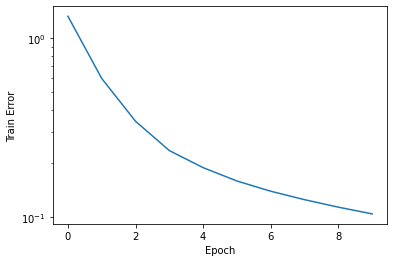

In [46]:
model = Neural_CF_Model(embed_size=50)
history = model.fit([train_data['user_encoded'], train_data['movie_encoded']], train_data['rating'], epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

In [47]:
y_pred = np.round(model.predict([test_data['user_encoded'], test_data['movie_encoded']]), decimals=2)
y_actual = test_data['rating']
print(f'testing rms: {(mean_squared_error(y_actual, y_pred))}')

testing rms: 0.20346602272322162


In [48]:
d = {'prediction': y_pred.tolist(), 'true_value': y_actual.tolist()}
test_pred = pd.DataFrame(d)
test_pred.head(5)

,prediction,true_value
0,[3.2300000190734863],3.0
1,[4.400000095367432],4.5
2,[3.859999895095825],3.5
3,[4.599999904632568],4.0
4,[5.210000038146973],3.5


In [49]:
user_counts = user_data.groupby('userId').size()

[(0.0, 600.0),
 (0.0, 400.0),
 Text(0.5, 1.0, 'User Ratings'),
 Text(0.5, 0, 'Number of Ratings')]

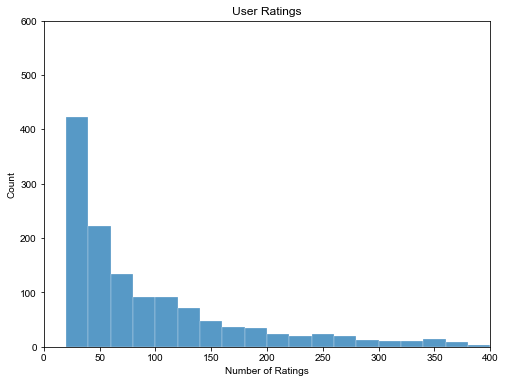

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.histplot(user_counts, binwidth=20, ax=ax)
ax.set(ylim=[0,600], xlim=[0,400], title='User Ratings', xlabel='Number of Ratings')

In [51]:
from sklearn.model_selection import KFold
valid_data_size = 10
valid_data = train_data.sample(n = int(valid_data_size), replace=False, random_state=236)
embedding_layers = [5, 10, 15, 20, 25, 30]

In [52]:
def NCF_cross_validation(cross_val_data, embedded_layers, drop_prob = 0.3, epoch=3, n_split=3):
    cross_val_res = []
    for layer in embedded_layers:
        loss = []
        i = 0
        for train_index, test_index in KFold(n_split).split(cross_val_data):
            cross_val_train_data = cross_val_data.iloc[train_index][['user_encoded', 'movie_encoded']]
            cross_val_test_data = cross_val_data.iloc[test_index][['user_encoded', 'movie_encoded']]
            cross_val_train_data_y = cross_val_data.iloc[train_index]['rating']
            cross_val_test_data_y = cross_val_data.iloc[test_index]['rating']
            model_cv = Neural_CF_Model()
            model_cv.fit([cross_val_train_data['user_encoded'], cross_val_train_data['movie_encoded']], cross_val_train_data_y, epochs=epoch)
            curr_loss = model_cv.evaluate([cross_val_data['user_encoded'], cross_val_data['movie_encoded']], cross_val_data['rating'])
            loss.append(curr_loss)
            i += 1
        cross_val_res.append(sum(loss) / n_split)
    return cross_val_res

In [53]:
def NCF_recommendation(rec_model, client_id, top_k = 20):
    client_encoded = user_en[client_id]
    movie_watched = user_data[user_data['userId'] == client_id]['movieId'].values
    movie_poll_encoded = []
    for item in movie_ids:
        if not np.isin(item, movie_watched):
            movie_poll_encoded.append(movie_en[item])
    d = {'user_encoded': [client_encoded] * len(movie_poll_encoded), 'movie_encoded' : movie_poll_encoded}
    client_df = pd.DataFrame(d)
    ratings = rec_model.predict([client_df['user_encoded'], client_df['movie_encoded']])
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [en_movie.get(movie_poll_encoded[x]) for x in top_ratings_idx]
    top_movie_rec = pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings}).set_index('movieId')
    top_movie_rec = top_movie_rec.join(movie_data.set_index('movieId'))
    return top_movie_rec

In [54]:
user_enter_id = int(np.random.choice(user_ID, 1))
print(f'recommendation for client: {user_enter_id}')
NCF_recommendation(model, user_enter_id, top_k=15)

recommendation for client: 1542


,prediction,title,genres
movieId,,,
1104,4.766817,"Streetcar Named Desire, A (1951)",Drama
82459,4.716903,True Grit (2010),Western
1947,4.627192,West Side Story (1961),Drama|Musical|Romance
541,4.603656,Blade Runner (1982),Action|Sci-Fi|Thriller
475,4.603393,In the Name of the Father (1993),Drama
2857,4.554109,Yellow Submarine (1968),Adventure|Animation|Comedy|Fantasy|Musical
16,4.551898,Casino (1995),Crime|Drama
1147,4.510539,When We Were Kings (1996),Documentary
5952,4.489670,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
